In [1]:
# Загрузка библиотек
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

### Ручное управление

#### Запуск и задача поворота колеса напрямую

In [2]:
# Подключение API
client = RemoteAPIClient()
sim = client.getObject('sim')

sim.startSimulation()

R_joint = sim.getObject('/Robot/Right_joint')
L_joint = sim.getObject('/Robot/Left_joint')

print("joint handels ", R_joint, L_joint)  # Проверка - хендлы должны быть целыми числами

# Переключение в режим POSITION
sim.setObjectInt32Param(R_joint, sim.jointintparam_ctrl_enabled, 1)
sim.setObjectInt32Param(L_joint, sim.jointintparam_ctrl_enabled, 1)
print("стартовое положение ", sim.getJointPosition(R_joint), sim.getJointPosition(L_joint))

R_pos = 170              # Целевой поворот в градусах
L_pos = 170                # важно учесть: 360=0, 181 = -1

R_pos *= np.pi/180       # перевод в радианы
L_pos *= np.pi/180
print("заданное положение ", R_pos, L_pos)

sim.setJointTargetPosition(R_joint, R_pos)
sim.setJointTargetPosition(L_joint, L_pos)

time.sleep(3)            # ждем и смотрим результат
print("итоговое положение ", sim.getJointPosition(R_joint), sim.getJointPosition(L_joint))
sim.stopSimulation()

joint handels  28 26
стартовое положение  4.001957679210126e-06 5.200709248590984e-06
заданное положение  2.9670597283903604 2.9670597283903604
итоговое положение  2.967077578839149 2.9670784382815842


#### Запуск и задача скорости напрямую

In [75]:
# Подключение API
client = RemoteAPIClient()
sim = client.getObject('sim')

sim.startSimulation()

R_joint = sim.getObject('/Robot/Right_joint')
L_joint = sim.getObject('/Robot/Left_joint')

print("joint handels ", R_joint, L_joint)  # Проверка - хендлы должны быть целыми числами

# Переключение в режим VELOCITY
sim.setObjectInt32Param(R_joint, sim.jointintparam_ctrl_enabled, 0)
sim.setObjectInt32Param(L_joint, sim.jointintparam_ctrl_enabled, 0)
print("стартовая скорость ", sim.getJointVelocity(R_joint), sim.getJointVelocity(L_joint))

R_vel = 1              # Целевой поворот в оборотах/сек
L_vel = 0.2              

R_vel *= 360*np.pi/180       # перевод в радианы
L_vel *= 360*np.pi/180
print("заданная скорость ", R_vel, L_vel)

sim.setJointTargetVelocity(R_joint, R_vel)
sim.setJointTargetVelocity(L_joint, L_vel)

time.sleep(3)            # ждем и смотрим результат
print("итоговая скорость ", sim.getJointVelocity(R_joint), sim.getJointVelocity(L_joint))
sim.stopSimulation()

joint handels  28 26
стартовая скорость  1.5718181701366227 0.002281048396846124
заданная скорость  6.283185307179586 1.2566370614359172
итоговая скорость  6.284217396367828 1.2578190697260458


### Управление сигналами

#### Cигнал на смену положения

In [2]:
# Подключение API
client = RemoteAPIClient()
sim = client.getObject('sim')

sim.startSimulation()

R_pos = 100            # Целевой поворот в градусах
L_pos = 100             

R_pos *= np.pi/180       # перевод в радианы
L_pos *= np.pi/180
print("заданное положение ", R_pos, L_pos)

sim.setInt32Signal("robot_mode_sig", 0)
sim.setFloatSignal("robot_R_sig", R_pos)
sim.setFloatSignal("robot_L_sig", L_pos)
sim.setInt32Signal("robot_set_sig", 1)     # Угадайте, почему это последним?

time.sleep(3)            # ждем и смотрим результат
sim.stopSimulation()

заданное положение  1.7453292519943295 1.7453292519943295


#### Сигнал на задание скорости

In [3]:
# Подключение API
client = RemoteAPIClient()
sim = client.getObject('sim')

sim.startSimulation()

R_vel = 1             # Целевой поворот в оборотах/сек
L_vel = 1              

R_vel *= 360*np.pi/180       # перевод в радианы
L_vel *= 360*np.pi/180
print("заданная скорость ", R_vel, L_vel)

sim.setInt32Signal("robot_mode_sig", 1)
sim.setFloatSignal("robot_R_sig", R_vel)
sim.setFloatSignal("robot_L_sig", L_vel)
sim.setInt32Signal("robot_set_sig", 1)     # Угадайте, почему это последним?

time.sleep(3)            # ждем и смотрим результат
sim.stopSimulation()

заданная скорость  6.283185307179586 6.283185307179586


### Класс для управления

In [2]:
class Robot_control():
    """ Класс управления для модели робота в CoppeliaSim """
    def __init__(self):
        self.wheel_R = 0.05    # справочная константа - размер колеса
        self.wheel_L = 0.115   # плечо крепления колес
        self.connect()         # подключение к копелии при создании объекта
        pass
    
    def connect(self):
        """ Подключение объекта к копелии """
        self.client = RemoteAPIClient()
        self.sim = self.client.getObject('sim')
            
    def get_handles(self):
        """ Получение хендлов объектов в сцене """
        try:
            self.robot = self.sim.getObject('/Robot')
            self.target = self.sim.getObject('/Target')
        except:
            print("Ошибка в поиске хендлов")

    def start(self):
        """ Запуск симуляции + хендлы """
        self.sim.startSimulation()
        self.get_handles()

    def stop(self):
        """ Стоп симуляции """
        self.sim.stopSimulation()
    
    def set_wheels_pos(self, q_RL):
        """ Установить колеса в положение """
        q_RL = np.array(q_RL, dtype=float) 
        q_RL *= np.pi/180       # перевод в радианы
        
        self.sim.setInt32Signal("robot_mode_sig", 0)
        self.sim.setFloatSignal("robot_R_sig", q_RL[0])
        self.sim.setFloatSignal("robot_L_sig", q_RL[1])
        self.sim.setInt32Signal("robot_set_sig", 1)

    def set_wheels_vel(self, w_RL):
        """ Установить скорость колес """ 
        w_RL = np.array(w_RL, dtype=float) 
        
        self.sim.setInt32Signal("robot_mode_sig", 1)
        self.sim.setFloatSignal("robot_R_sig", w_RL[0])
        self.sim.setFloatSignal("robot_L_sig", w_RL[1])
        self.sim.setInt32Signal("robot_set_sig", 1)

    def get_robot_in_world(self):
        """ Получение координат робота в СК мира """
        pos = self.sim.getObjectPosition(self.robot)
        orient = self.sim.getObjectOrientation(self.robot)
        return np.array( [pos[0], pos[1], orient[2]*180/np.pi] )

    def TP_robot_in_world(self, pose):
        """ Телепортация робота в координаты в СК мира """
        # АПИ копелии плохо работает с numpy
        if isinstance(pose, np.ndarray):
            pose = pose.astype(float).tolist()
        
        _pos = self.sim.getObjectPosition(self.robot)
        _orient = self.sim.getObjectOrientation(self.robot)
        _pos[0], _pos[1], _orient[2] = pose[0], pose[1], pose[2]*np.pi/180
        self.sim.setObjectPosition(self.robot, _pos)
        self.sim.setObjectOrientation(self.robot, _orient)

    def get_target_in_world(self):
        """ Получение координат цели в СК мира """
        pos = self.sim.getObjectPosition(self.target)
        orient = self.sim.getObjectOrientation(self.target)
        return np.array( [pos[0], pos[1], orient[2]*180/np.pi] )

    def get_target_in_robot(self):
        """ Получения координат цели в СК робота """
        pos = self.sim.getObjectPosition(self.target, self.robot)
        orient = self.sim.getObjectOrientation(self.target, self.robot)
        return np.array( [pos[0], pos[1], orient[2]*180/np.pi] )

    def set_target_in_world(self, pose):
        """ Установка координат цели в СК мира """
        # АПИ копелии плохо работает с numpy
        if isinstance(pose, np.ndarray):
            pose = pose.astype(float).tolist()
        
        _pos = self.sim.getObjectPosition(self.target)
        _orient = self.sim.getObjectOrientation(self.target)
        _pos[0], _pos[1], _orient[2] = pose[0], pose[1], pose[2]*np.pi/180
        self.sim.setObjectPosition(self.target, _pos)
        self.sim.setObjectOrientation(self.target, _orient)

    def set_target_in_robot(self, pose):
        """ Установка координат цели в СК робота """
        # АПИ копелии плохо работает с numpy
        if isinstance(pose, np.ndarray):
            pose = pose.astype(float).tolist()
        
        _pos = self.sim.getObjectPosition(self.target, self.robot)
        _orient = self.sim.getObjectOrientation(self.target, self.robot)
        _pos[0], _pos[1], _orient[2] = pose[0], pose[1], pose[2]*np.pi/180
        self.sim.setObjectPosition(self.target, _pos, self.robot)
        self.sim.setObjectOrientation(self.target, _orient, self.robot)

#### Извлечение координат со сцены

In [5]:
stend = Robot_control()
stend.start()

print("Робот в СК мира ", stend.get_robot_in_world())
print("Цель в СК мира ", stend.get_target_in_world())
print("Цель в СК робота ", stend.get_target_in_robot())

stend.stop()

Робот в СК мира  [9.49999495e-01 2.50005737e-02 9.00010798e+01]
Цель в СК мира  [  1.45    0.925 -40.   ]
Цель в СК робота  [   0.89996279   -0.50006572 -130.00412706]


#### Установка положения робота и цели

In [6]:
stend = Robot_control()
stend.start()

stend.TP_robot_in_world([0, 0, 90])
stend.set_target_in_world([1, 0, 90])
time.sleep(1)
stend.set_target_in_robot([1, 0, 90])

time.sleep(2)            # ждем и смотрим результат
stend.stop()

#### Задание движения через класс

In [57]:
stend = Robot_control()
stend.start()

stend.TP_robot_in_world([0, 0, 0])
time.sleep(1)  
stend.set_wheels_pos([100,100])
time.sleep(1)  
stend.set_wheels_vel(np.array([5,2]))

time.sleep(3)            # ждем и смотрим результат
stend.stop()

### Управление с обратной связью

In [76]:
stend = Robot_control()
stend.start()

In [23]:
stend.stop()

In [3]:
# Вспомогательный класс для отрисовки графиков при настройке регуляторов
class Log_graf:
    _storage = None
    _size = 5

    @classmethod
    def add_new(cls, item=None):
        if cls._storage is None:
            cls._storage = [[]]
        elif len(cls._storage) >= cls._size:
            cls._storage.pop(0)
            cls._storage.append([])
        else:
            cls._storage.append([])
        if not item is None:
            cls.add(item)
    
    @classmethod
    def add(cls, item):
        if cls._storage is None:
            cls.add_new(item)
        else:
            cls._storage[-1].append(item)
    
    @classmethod
    def get(cls):
        return cls._storage if cls._storage is not None else []
    
    @classmethod
    def clear(cls):
        cls._storage = None

    @classmethod
    def set_size(cls, n:int):
        """ Задает число хранимых графиков """
        if n > 0:     cls._size = n

    @classmethod
    def show(cls):
        clear_output(wait=True)
        plt.figure(figsize=(8, 4))
        for i, y in enumerate(cls._storage):
            x = np.linspace(0, len(y), len(y))
            plt.plot(x, y, 'b-', linewidth=0.2*(i+1))
        plt.grid(True, alpha=0.3)
        plt.show()

#### Регулятор ориентации релейный

Дано: робот; цель; вектор цели в системе координат робота
Цель: чтобы положение робота совпало с положением цели
       вектор положения цели в этом случае равен нулю
       следовательно, вектор положения цели в координатах робота это вектор ошибки

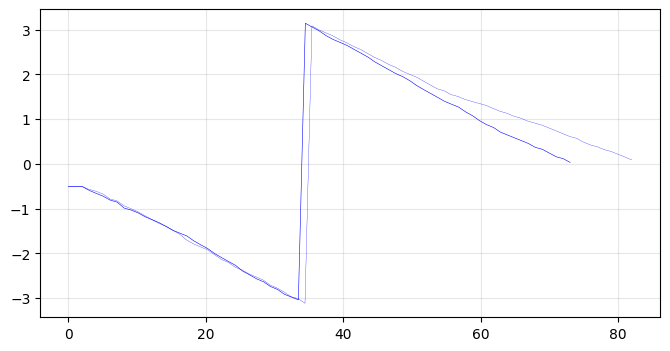

In [7]:
try: # Обертка для обработки аварийного прерывания
    
    # Поскольку робот неголономный, сперва повернем к цели
    stend = Robot_control()
    stend.start()

    # вектор ошибки в координатах робота
    target_r =  stend.get_target_in_robot()
    # угло доворота на цель
    azimut = np.arctan2(target_r[1], target_r[0])
    Log_graf.add_new(azimut)
    
    w, eps = 1.0, 0.1
    # Крутим робота, пока доворот по модулю не уменьшится до допустимого
    while abs(azimut) > eps:     
        target_r =  stend.get_target_in_robot()
        azimut = np.arctan2(target_r[1], target_r[0])
        Log_graf.add(azimut)
        stend.set_wheels_vel([w, -w])
    # Проблемы:
    # при малой допустимой ошибке или большой скорости, есть риск проскочить
    # Направление вращения нужно угадать

    stend.set_wheels_vel([0, 0])
    Log_graf.show()
    time.sleep(2)
    
except KeyboardInterrupt:
    Log_graf.show()
    stend.stop()
    
finally:
    stend.stop()

#### Регулятор ориентации пропорциональный

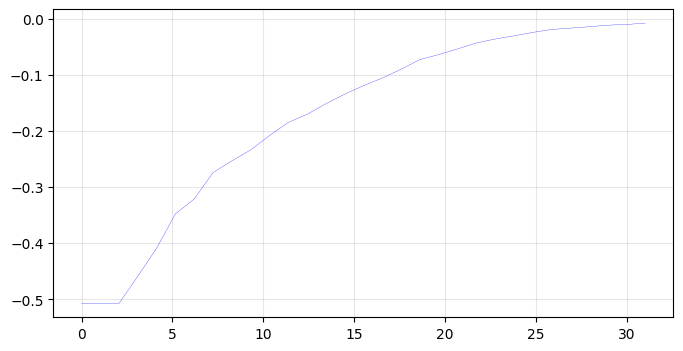

In [ ]:
try:
    stend = Robot_control()
    stend.start()
    
    p, eps = 1.5, 0.01
    target_r =  stend.get_target_in_robot()
    azimut = np.arctan2(target_r[1], target_r[0])
    Log_graf.add_new(azimut)
    
    while abs(azimut) > eps:     
        target_r =  stend.get_target_in_robot()
        azimut = np.arctan2(target_r[1], target_r[0])
        stend.set_wheels_vel([azimut * p, -azimut * p])
        Log_graf.add(azimut)
    # Проблемы:
    # Скорость сигнал не равен скорости движения
    # Сложно использовать повторно
    # попробуй поставить w = 10))
    # заметим возвратное движение. Зато точность можно повысить
    
    stend.set_wheels_vel([0, 0])
    Log_graf.show()
    time.sleep(2)

except KeyboardInterrupt:
    Log_graf.show()
    stend.stop()
    
finally:
    stend.stop()

#### Регулятор ориентации в форме функции

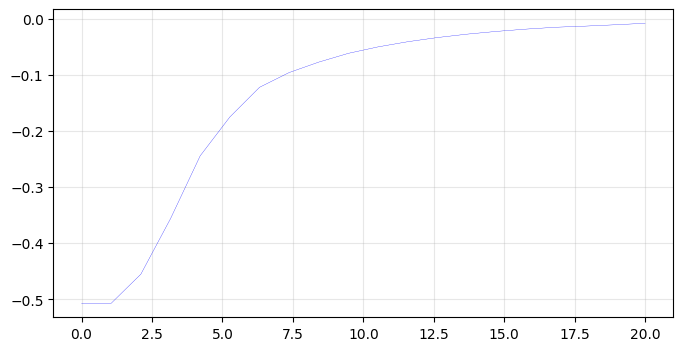

In [ ]:
try:
    stend = Robot_control()
    stend.start()
    Log_graf.clear()
    def azimut_P_control(e, kp, max_w=20):
        # При повороте робота колесо движется по окружности радиусом R = wheel_L
        # (где wheel_L — расстояние от центра робота до колеса)
        # Длина дуги: s = a * wheel_R  (a — угол поворота колеса в рад, wheel_R - радиус колеса)
        # Угол поворота робота: φ = s / R_base = a * wheel_R / wheel_L
        # Отсюда: для поворота на φ нужно повернуть колесо на a = φ * wheel_L / wheel_R
        w = e * kp * stend.wheel_L/stend.wheel_R        
        # ограничение скорости
        w  = np.clip(w, -max_w, max_w)
        return np.array([1, -1]) * w   #сигнал на 2 колеса
    
    kp, eps = 3, 0.01

    Log_graf.add_new()

    err = 10*eps  # значение чтобы войти в цикл
    while abs(err) > eps:   
        target_r =  stend.get_target_in_robot()
        # азимут не равный 0 это ошибка
        err = np.arctan2(target_r[1], target_r[0])  
        stend.set_wheels_vel(azimut_P_control(err, kp))
        Log_graf.add(err)
        
    stend.set_wheels_vel([0, 0])
    Log_graf.show()
    time.sleep(2)

except KeyboardInterrupt:
    Log_graf.show()
    stend.stop()
    
finally:
    stend.stop()

#### Регулятор движения упрощенный

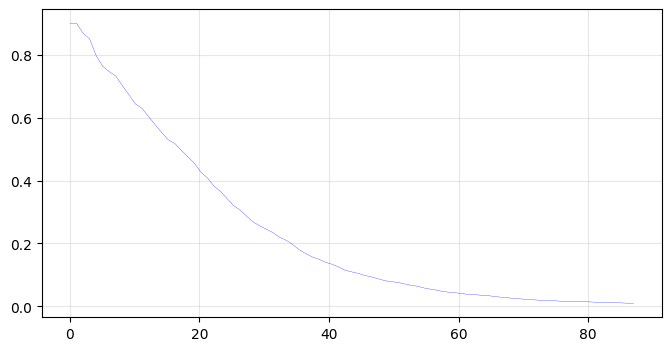

In [5]:
try:
    stend = Robot_control()
    stend.start()
    Log_graf.clear()
    def dist_P_control(e, kp, max_v=300):
        # При повороте колеса на a робот проходит a*wheel_R
        v = e * kp * stend.wheel_R        
        # ограничение скорости
        v  = np.clip(v, -max_v, max_v)
        return np.array([1, 1]) * v   #сигнал на 2 колеса
    
    kp, eps = 160, 0.01

    Log_graf.add_new()

    err = 10*eps  # значение чтобы войти в цикл
    while abs(err) > eps:   
        target_r =  stend.get_target_in_robot()
        # ошибка дистанции равна х координате цели в СК робота
        # при условии что цель прямо перед роботом
        err = target_r[0]
        stend.set_wheels_vel(dist_P_control(err, kp))
        Log_graf.add(err)
        
    stend.set_wheels_vel([0, 0])
    Log_graf.show()
    time.sleep(2)

except KeyboardInterrupt:
    Log_graf.show()
    stend.stop()
    
finally:
    stend.stop()

#### Поворот затем движение

In [78]:
try:
    stend = Robot_control()
    stend.start()
    
    eps = 0.01

    # Доворот к цели
    err = 10*eps  # значение чтобы войти в цикл
    while abs(err) > eps:   
        target_r =  stend.get_target_in_robot()
        # азимут не равный 0 это ошибка
        err = np.atan2(target_r[1], target_r[0])  
        stend.set_wheels_vel(azimut_P_control(err, 4))
    
    # Движение вперед
    err = 10*eps  # значение чтобы войти в цикл
    while abs(err) > eps:   
        target_r =  stend.get_target_in_robot()
        # ошибка дистанции равна х координате цели в СК робота
        # при условии что цель прямо перед роботом
        err = target_r[0]
        stend.set_wheels_vel(dist_P_control(err, 800))
        
    stend.set_wheels_vel([0, 0])
    time.sleep(2)

except KeyboardInterrupt:
    stend.stop()
    
finally:
    stend.stop()

#### Совместное регулирование 

In [85]:
try:
    stend = Robot_control()
    stend.start()
    
    eps = 0.01

    err = 10*eps  # значение чтобы войти в цикл
    while abs(err) > eps:   
        target_r =  stend.get_target_in_robot()
        # азимут не равный 0 это ошибка
        err_a = np.atan2(target_r[1], target_r[0])  
        err_d = target_r[0]
        err = err_a + err_d
        stend.set_wheels_vel(azimut_P_control(err_a, 4) + dist_P_control(err_d, 600))
        
    stend.set_wheels_vel([0, 0])
    time.sleep(2)

except KeyboardInterrupt:
    stend.stop()
    
finally:
    stend.stop()

#### Функция движения

In [90]:
# движение по маршруту 
def move_to(pose):
    # Функция движения к цели 
    stend.set_target_in_world(pose)
    
    eps = 0.01
    err = 10*eps  # значение чтобы войти в цикл
    while abs(err) > eps:   
        target_r =  stend.get_target_in_robot()
        # азимут не равный 0 это ошибка
        err_a = np.atan2(target_r[1], target_r[0])  
        err_d = target_r[0]
        err = err_a + err_d
        stend.set_wheels_vel(azimut_P_control(err_a, 4) + dist_P_control(err_d, 600))

try:
    stend = Robot_control()
    stend.start()

    move_to([0.25, 1.25, 0])
    move_to([1.25, 1.25, 0])
    move_to([2.25, 0.5, 0])
    move_to([1.75, 1.25, 0])
            
except KeyboardInterrupt:
    stend.stop()
    
finally:
    time.sleep(1) 
    stend.stop()

### Попробовать самостоятельно

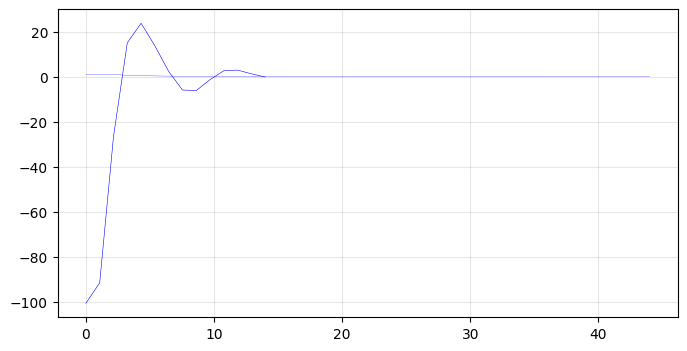

In [ ]:
# Реализовать поворот в соответствии с ориентацией маркера цели
try:
    stend = Robot_control()
    stend.start()
    Log_graf.clear()

    def wrap_to_pi(angle_rad):
        return (angle_rad + np.pi) % (2 * np.pi) - np.pi

    def azimut_P_control(e, kp=4.0, max_w=18.0):
        w = np.clip(e * kp * stend.wheel_L / stend.wheel_R, -max_w, max_w)
        return np.array([1, -1]) * w

    def dist_P_control(e, kp=500.0, max_v=220.0):
        v = np.clip(e * kp * stend.wheel_R, -max_v, max_v)
        return np.array([1, 1]) * v

    eps_pos = 0.01
    eps_ang = np.deg2rad(1.0)
    dt = 0.05
    max_time_position = 8.0
    max_time_turning = 15.0
    
    Log_graf.add_new()
    t0 = time.time()
    while True:
        target_r = stend.get_target_in_robot()
        err_a = np.arctan2(target_r[1], target_r[0])
        err_d = np.hypot(target_r[0], target_r[1])

        if err_d > 0.12:
            cmd = azimut_P_control(err_a, kp=4.0) + dist_P_control(err_d, kp=450.0)
        else:
            cmd = azimut_P_control(err_a, kp=6.0)

        stend.set_wheels_vel(cmd)
        Log_graf.add(err_d)

        if err_d < eps_pos or (time.time() - t0) > max_time_position:
            break
        time.sleep(dt)

    stend.set_wheels_vel([0, 0])
    time.sleep(0.2)

    Log_graf.add_new()
    err_o = 10 * eps_ang
    t0 = time.time()
    while abs(err_o) > eps_ang and (time.time() - t0) < max_time_turning:
        target_r = stend.get_target_in_robot()
        err_o = wrap_to_pi(np.deg2rad(target_r[2]))
        stend.set_wheels_vel(azimut_P_control(err_o, kp=4.0, max_w=14.0))
        Log_graf.add(np.rad2deg(err_o))
        time.sleep(dt)

    stend.set_wheels_vel([0, 0])
    Log_graf.show()
    time.sleep(1.5)

except KeyboardInterrupt:
    stend.stop()

finally:
    time.sleep(0.5)
    stend.stop()

In [ ]:
# Провести робот по лабиринту
try:
    stend = Robot_control()
    stend.start()

    def azimut_P_control(e, kp=4.0, max_w=16.0):
        w = np.clip(e * kp * stend.wheel_L / stend.wheel_R, -max_w, max_w)
        return np.array([1, -1]) * w

    def dist_P_control(e, kp=500.0, max_v=220.0):
        v = np.clip(e * kp * stend.wheel_R, -max_v, max_v)
        return np.array([1, 1]) * v

    # Настройки маршрута
    dt = 0.05
    eps_position = 0.1
    eps_angle = 0.2
    time_to_finish = 7.0

    def move_to(pose):
        stend.set_target_in_world(pose)
        t0 = time.time()

        while True:
            target_r = stend.get_target_in_robot()
            err_a = np.arctan2(target_r[1], target_r[0])
            err_d = np.hypot(target_r[0], target_r[1])

            if err_d > 0.16:
                summary_err = azimut_P_control(err_a) + dist_P_control(err_d)
            else:
                summary_err = azimut_P_control(err_a, kp=5.5)

            stend.set_wheels_vel(cmd)

            if err_d < eps_position and abs(err_a) < eps_angle:
                break
            if time.time() - t0 > time_to_finish:
                break

            time.sleep(dt)

    route = [
        [0.25, 0.25, 0],
        [1.25, 1.0, 0],
        [2.25, 0.5, 0],
        [2.75, 1.0, 0],
    ]

    stend.TP_robot_in_world(route[0])

    for p in route[1:]:
        move_to(p)

    stend.set_wheels_vel([0, 0])
    time.sleep(1.5)

except KeyboardInterrupt:
    stend.stop()

finally:
    time.sleep(0.5)
    stend.stop()


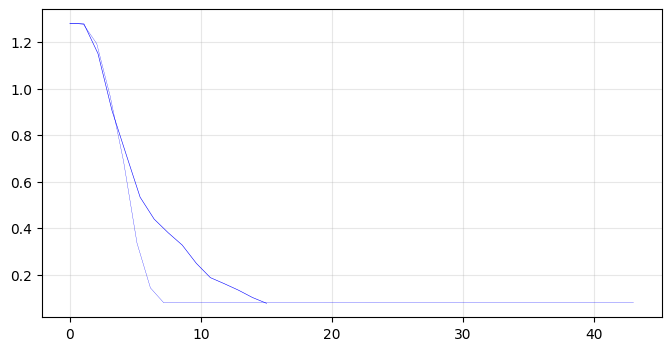

In [36]:
# Попробовать собрать PI и PID регуляторы
try:
    stend = Robot_control()
    stend.start()
    Log_graf.clear()

    def wrap_to_pi(angle_rad):
        return (angle_rad + np.pi) % (2 * np.pi) - np.pi

    def run_controller(target_pose, mode='PI', dt=0.05, timeout=10.0):
        stend.set_target_in_world(target_pose)

        kp_a, ki_a, kd_a = 2.0, 0.20, 0.35
        kp_d, ki_d, kd_d = 1.5, 0.25, 0.20

        i_a = 0.0
        i_d = 0.0
        prev_a = 0.0
        prev_d = 0.0

        t0 = time.time()
        while True:
            target_r = stend.get_target_in_robot()
            err_a = wrap_to_pi(np.arctan2(target_r[1], target_r[0]))
            err_d = np.hypot(target_r[0], target_r[1])

            if abs(err_d) < 1.5:
                i_a += err_a * dt
                i_d += err_d * dt

            i_a = np.clip(i_a, -0.8, 0.8)
            i_d = np.clip(i_d, -0.8, 0.8)

            d_a = (err_a - prev_a) / dt
            d_d = (err_d - prev_d) / dt
            prev_a, prev_d = err_a, err_d

            d_a = np.clip(d_a, -3.0, 3.0)
            d_d = np.clip(d_d, -2.0, 2.0)

            if mode == 'PI':
                u_w = kp_a * err_a + ki_a * i_a
                u_v = kp_d * err_d + ki_d * i_d
            else:
                u_w = kp_a * err_a + ki_a * i_a + kd_a * d_a
                u_v = kp_d * err_d + ki_d * i_d + kd_d * d_d

            if abs(err_d) < 0.1:
                u_v = 0.0
                u_w = 0.8 * u_w

            w_turn = np.clip(u_w * stend.wheel_L / stend.wheel_R, -12, 12)
            w_move = np.clip(u_v / stend.wheel_R, -120, 120)
            cmd = np.array([1, -1]) * w_turn + np.array([1, 1]) * w_move
            stend.set_wheels_vel(cmd)

            Log_graf.add(err_d)

            if abs(err_d) < 0.1:
                err_o = wrap_to_pi(np.deg2rad(stend.get_target_in_robot()[2]))
                if abs(err_o) < np.deg2rad(2.0):
                    break

            if (time.time() - t0) > timeout:
                break

            time.sleep(dt)

        stend.set_wheels_vel([0, 0])

    for mode in ['PI', 'PID']:
        stend.TP_robot_in_world([0.0, 0.0, 0])
        stend.set_target_in_world([1.0, 0.8, 90])
        Log_graf.add_new()
        run_controller([1.0, 0.8, 90], mode=mode, timeout=10.0)
        time.sleep(0.6)

    Log_graf.show()
    time.sleep(1.5)

except KeyboardInterrupt:
    stend.stop()

finally:
    time.sleep(0.5)
    stend.stop()
